# Hospital Readmission Prediction

### A hospital readmission is when a patient who is discharged from a hospital, gets re-admitted again within a certain period of time. Readmission rates for certain conditions are now considered an indicator of hospital quality, and also affect the cost of care adversely. Being able to determine factors that lead to higher readmission in such patients, and correspondingly being able to predict which patients will get readmitted can help hospitals save millions of dollars while improving quality of care. So, with that background in mind, we build models to predict the readmission rate 

#### Dataset -> https://archive.ics.uci.edu/ml/datasets/diabetes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report


### Column Info

- encounter_id : Patient encounter ID
- patient_nbr : Patient nbr code                
- race : Race                           
- gender : Gender                     
- age : Age in categories                            
- weight : Weight                         
- admission_type_id : admission id          
- discharge_disposition_id : dishacharge id       
- admission_source_id  : source id           
- time_in_hospital : time spent in hospital             
- payer_code  : payer code
- medical_specialty : Medical Specialty
- diag_1 : diagnosis 1
- diag_2 : diagnosis 2
- diag_3 : diagnosis 3
- number_diagnoses : Total diagnosis
- max_glu_serum  : Max Gluten level
- A1Cresult  : A1 test results
- Medication change for Different Drugs : (metformin ,repaglinide,nateglinide  chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamine examide citoglipton insulin glyburide-metform glipizide-metformin glimepiride-pioglitazone  metformin-rosiglitazone metformin-pioglitone )
- diabetesMed : Diabetic Medication
- readmitted : Patient Readmiited or not

### Data Pre Processing

In [2]:
df = pd.read_csv("diabetic_data.csv")

In [3]:
# Find the nulk and na values in the columns 
totalRows = df.shape[0]
# The columns 'weight','payer_code','medical_specialty' have more than 40% of values as "?" so drop them
# Also drop other unnecassary columns such as encounterid and patient nbr
# drop examide and citoglipton since they have same values
droppedColumns =['encounter_id','patient_nbr','weight','payer_code','medical_specialty','citoglipton','examide']
df = df.drop(droppedColumns, axis = 1)
df = df[df.gender != "Unknown/Invalid"] #since gender has few invalid values

#Dropping rows with ? in race
df = df[df.race != "?"] #since gender has few invalid values

#Dropping max_glu_serum and A1Cresult since 90% of the values are None 

#Removing other unnecassry columns with id values which does not relate to readmission prediction
df=df.drop(['max_glu_serum','A1Cresult','admission_type_id','discharge_disposition_id','admission_source_id',
           'diag_1','diag_2','diag_3'], axis = 1)

### Replacing the categorical values by numeric values
##### There is no ordinal relationship within these variables. 
##### Using get_dummies to perform One Hot encoding and dropping one of the columns from the encoded features to avoid multi collinearity

In [4]:
df = pd.get_dummies(data=df, columns=['change', 'gender','diabetesMed'], drop_first=True) 
#drop_first=True --> drops one of the column from the encoded features

#Recoding the outcome variable. 
#Whether the patient is readmitted within 30 days or not.#There are 3 categories, < 30, > 30 and No.
#To reduce this to a binary classification, we combine readmission after 30 days and no readmission into one category:
df['readmitted'] = df['readmitted'].map({'<30': 1, '>30':0, 'NO':0})

# Similarly encoded different drugs with numerical values
                                        
#Replacing Categorical Values with Numerical Values with one hod encoding
drugsNames = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone',
        'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
        'insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone',
        'metformin-rosiglitazone']

for drug in drugsNames:
    df[drug] = df[drug].map({'Steady': 1, 'Up':1, 'Down':1, 'No': 0})

#### Splitting Age into different categories and converting it into numerical values

In [5]:
# Mapping ages to different categories
ageByCategories = {'[0-10)':'kids', 
                   '[10-20)':'teens', 
                   '[20-30)':'adults', '[30-40)':'adults', '[40-50)':'adults', '[50-60)':'adults', 
                   '[60-70)':'elderly', '[70-80)':'elderly', '[80-90)':'elderly', '[90-100)':'elderly'}
df['age'] = df['age'].map(ageByCategories)
#Converting Race and Age which are categorical into numerical values
df = pd.get_dummies(data=df, columns=['race','age'], drop_first=True)

In [6]:
#df.to_csv('./processedData.csv')

### Box plot to show distrubution of values in the numerical columns

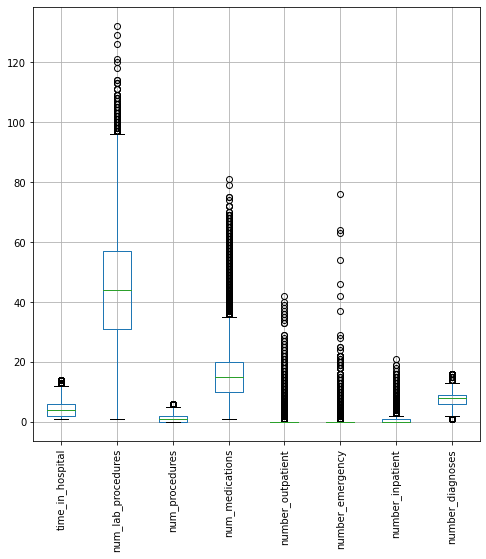

Shape after removing outlier is  (22612, 40)


In [7]:
numericalColumns = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
                   'number_emergency','number_inpatient','number_diagnoses']
allColumns = df.columns
categoricalColumns = []
for c in allColumns:
    if c not in numericalColumns:
        categoricalColumns.append(c)
        df[c] = df[c].astype('object')
categoricalColumns.remove('readmitted')

boxplot = df.boxplot(column=numericalColumns,rot=90,fontsize=10,figsize=(8,8))
plt.show()
#This shows the outliers in each column and outliers has to be removed
df_Copy=df
for c in numericalColumns:
    col = df_Copy[c]
    d = df_Copy[col.between(col.quantile(.15), col.quantile(.85))] # without outliers
    df_Copy=d
print("Shape after removing outlier is ",d.shape)

In [8]:
d.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,22612.000000,22612.000000,22612.000000,22612.000000,22612.000000,22612.0,22612.000000,22612.000000
mean,4.056121,45.028657,0.809526,14.671148,0.070140,0.0,0.236335,7.725057
std,1.724973,10.471177,1.019613,3.689335,0.255388,0.0,0.424839,1.504400
min,2.000000,23.000000,0.000000,9.000000,0.000000,0.0,0.000000,5.000000
25%,3.000000,37.000000,0.000000,12.000000,0.000000,0.0,0.000000,6.000000
50%,4.000000,45.000000,0.000000,14.000000,0.000000,0.0,0.000000,8.000000
75%,5.000000,54.000000,1.000000,17.000000,0.000000,0.0,0.000000,9.000000
max,8.000000,63.000000,3.000000,22.000000,1.000000,0.0,1.000000,9.000000


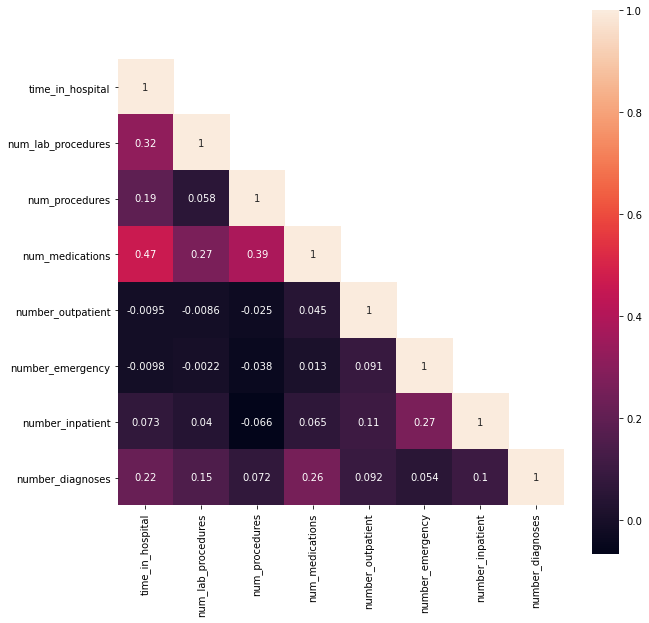

In [9]:
corr_df = df[numericalColumns]
cor_mat = corr_df.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data=cor_mat, mask=mask, square=True, annot=True, cbar=True)
plt.show()

### Cross Validation Train-Test Split

In [10]:
x = d.drop(['readmitted'],axis=1)
y = d['readmitted']
y=y.astype('int')

In [11]:
#Using minmax scaler to perform scaling on the numerical columns.Also the data is not normally distributed 
#Each numerical features are now on a common range from 0 to 1

scaler = MinMaxScaler()

x_train_org, x_test_org, y_train, y_test = train_test_split(x,y,random_state=0)

x_train_new = scaler.fit_transform(x_train_org[numericalColumns])
x_train_arr = np.concatenate((x_train_new, x_train_org[categoricalColumns]), axis=1)
x_train = pd.DataFrame(data=x_train_arr, columns=x_train_org.columns)

x_test_new = scaler.transform(x_test_org[numericalColumns])
x_test_arr = np.concatenate((x_test_new, x_test_org[categoricalColumns]), axis=1)
x_test = pd.DataFrame(data=x_test_arr, columns=x_test_org.columns)


x_train[numericalColumns] = x_train[numericalColumns].apply(pd.to_numeric)
x_test[numericalColumns] = x_test[numericalColumns].apply(pd.to_numeric)


### Hard Voting

In [12]:
log_clf = LogisticRegression(penalty = 'l1', C = 10, random_state = 0,solver='liblinear')
log_clf.fit(x_train, y_train)

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(x_train, y_train)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('knn', knn_clf)],voting='hard')
voting_clf.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (log_clf, knn_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.894746152485406
KNeighborsClassifier 0.8747567663187688
VotingClassifier 0.894746152485406


### Soft Voting

In [13]:
log_clf = LogisticRegression(penalty = 'l1', C = 10, random_state = 0,solver='liblinear')
log_clf.fit(x_train, y_train)

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(x_train, y_train)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('knn', knn_clf)],voting='soft')
voting_clf.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (log_clf, knn_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.894746152485406
KNeighborsClassifier 0.8747567663187688
VotingClassifier 0.8933309747036972


### Bagging

In [14]:
dt_clf = DecisionTreeClassifier(random_state=0)
bag_clf1 = BaggingClassifier(dt_clf, n_estimators=300, max_samples=2000, bootstrap=True, n_jobs=-1, random_state=0)
bag_clf1.fit(x_train, y_train)
print('Decision Tree - Bagging')
print('Train score: {:.3f}'.format(bag_clf1.score(x_train, y_train)))
print('Test score: {:.3f}'.format(bag_clf1.score(x_test, y_test)))

Decision Tree - Bagging
Train score: 0.900
Test score: 0.895


In [15]:
svclinear = SVC(kernel='linear')
bag_clf2 = BaggingClassifier(svclinear, n_estimators=100, max_samples=500, bootstrap=True, n_jobs=-1, random_state=0)
bag_clf2.fit(x_train, y_train)
print('SVC - Bagging')
print('Train score: {:.3f}'.format(bag_clf2.score(x_train, y_train)))
print('Test score: {:.3f}'.format(bag_clf2.score(x_test, y_test)))

SVC - Bagging
Train score: 0.899
Test score: 0.895


### Pasting

In [16]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
bag_clf3 = BaggingClassifier(knn_clf, n_estimators=100, max_samples=500, bootstrap=False, n_jobs=-1, random_state=0)
bag_clf3.fit(x_train, y_train)
print('KNN claasifier - Pasting')
print('Train score: {:.3f}'.format(bag_clf3.score(x_train, y_train)))
print('Test score: {:.3f}'.format(bag_clf3.score(x_test, y_test)))

KNN claasifier - Pasting
Train score: 0.899
Test score: 0.895


In [17]:
log_clf = LogisticRegression(solver='liblinear')
bag_clf4 = BaggingClassifier(log_clf, n_estimators=100, max_samples=2000, bootstrap=False, n_jobs=-1, random_state=0)
bag_clf4.fit(x_train, y_train)
print('Logistic Classifier - Pasting')
print('Train score: {:.3f}'.format(bag_clf4.score(x_train, y_train)))
print('Test score: {:.3f}'.format(bag_clf4.score(x_test, y_test)))

Logistic Classifier - Pasting
Train score: 0.899
Test score: 0.895


### Adaboost Boosting


In [18]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=0)
ada_clf.fit(x_train, y_train)
print('Decision Tree - AdaBoost Classifier')
print('Test score: {:.3f}'.format(ada_clf.score(x_test, y_test)))
print(classification_report(y_test, ada_clf.predict(x_test), digits=4))

Decision Tree - AdaBoost Classifier
Test score: 0.895
              precision    recall  f1-score   support

           0     0.8949    0.9998    0.9444      5059
           1     0.0000    0.0000    0.0000       594

    accuracy                         0.8947      5653
   macro avg     0.4475    0.4999    0.4722      5653
weighted avg     0.8009    0.8947    0.8452      5653



In [19]:
svc = LinearSVC(random_state=0)
abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,algorithm="SAMME",learning_rate=1)
abc.fit(x_train, y_train)
print('Linear SVC - AdaBoost Classifier')
print('Test score: {:.3f}'.format(abc.score(x_test, y_test)))

Linear SVC - AdaBoost Classifier
Test score: 0.895


### Gradient Boosting

In [20]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(x_test, y_test)))

Accuracy on training set: 0.900
Accuracy on test set: 0.895


### PCA

In [21]:
pca = PCA(n_components=0.95)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
pca.n_components_

18

### Logistic 

In [22]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x_train, y_train)
c_space = np.logspace(0,5,10)
param_grid = {'C': c_space,'penalty': ['l1','l2']}
grid1 = GridSearchCV(logreg, param_grid, cv=5,return_train_score=True)
grid1.fit(x_train,y_train)
print('Best value of C in Logistic Regression is ' + str(grid1.best_params_))
print("Best Accuracy of the model when C is " + str(grid1.best_params_)+ " is " + str(grid1.best_score_))
result = pd.DataFrame(grid1.cv_results_)


Best value of C in Logistic Regression is {'C': 1.0, 'penalty': 'l1'}
Best Accuracy of the model when C is {'C': 1.0, 'penalty': 'l1'} is 0.8994634103592751


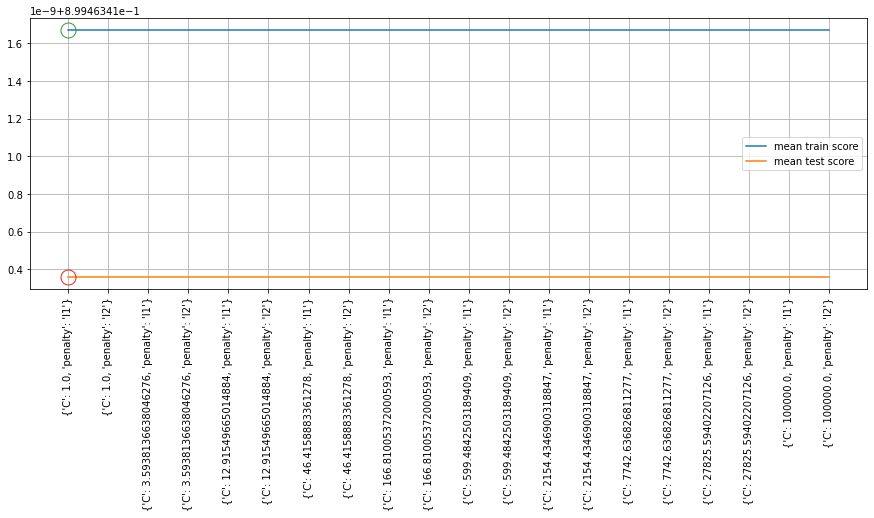

In [23]:
%matplotlib inline
plt.subplots(figsize = (15,5))
plt.plot(range(result['params'].shape[0]), result['mean_train_score'], label = 'mean train score')
plt.plot(range(result['params'].shape[0]), result['mean_test_score'], label = 'mean test score')
plt.xticks(range(result['params'].shape[0]), result['params'], rotation = 90)
plt.plot([grid1.best_index_], result['mean_train_score'][grid1.best_index_], 'o', markersize = 15, fillstyle = 'none')
plt.plot([grid1.best_index_], result['mean_test_score'][grid1.best_index_], 'o', markersize = 15, fillstyle = 'none')
plt.legend()
plt.grid()

In [24]:
log_l1 = LogisticRegression(C=1, penalty='l1', solver='liblinear')
log_l1.fit(x_train, y_train)
print('Accuracy on test set: {:.3f}'.format(log_l1.score(x_test, y_test)))
y_pred = log_l1.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.895
[[5059    0]
 [ 594    0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5059
           1       0.00      0.00      0.00       594

    accuracy                           0.89      5653
   macro avg       0.45      0.50      0.47      5653
weighted avg       0.80      0.89      0.85      5653



## KNN Classifier

KNN Accuracy Train: 0.8994634117577688
KNN Accuracy Test: 0.8745798690960552


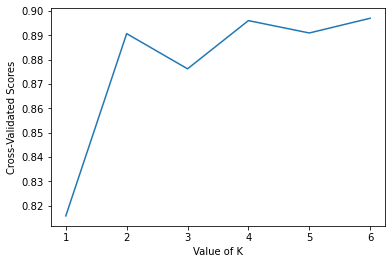

In [25]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
y_pred_train = logreg.predict(x_train)
print("KNN Accuracy Train:",metrics.accuracy_score(y_train, y_pred_train))
print("KNN Accuracy Test:",metrics.accuracy_score(y_test, y_pred))

k_scores=[]
k_range = range(1,7)
for k in k_range:
    knn= KNeighborsClassifier(n_neighbors=k)
    k_scores.append(cross_val_score(knn,x,y,cv=3).mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of K')
plt.ylabel('Cross-Validated Scores')
plt.show()

In [26]:
from sklearn.neighbors import KNeighborsClassifier

train_score_array = []
test_score_array = []

for k in range(1,7):
    knn = KNeighborsClassifier(k)
    knn.fit(x_train, y_train)
    train_score_array.append(knn.score(x_train, y_train))
    test_score_array.append(knn.score(x_test, y_test))

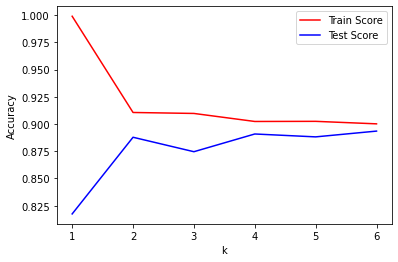

In [27]:
x_axis = range(1,7)
%matplotlib inline
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'r')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(x_train, y_train)
print('Accuracy on train set: {:.3f}'.format(knn.score(x_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(knn.score(x_test, y_test)))
y_pred = knn.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on train set: 0.900
Accuracy on test set: 0.894
[[5051    8]
 [ 594    0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5059
           1       0.00      0.00      0.00       594

    accuracy                           0.89      5653
   macro avg       0.45      0.50      0.47      5653
weighted avg       0.80      0.89      0.84      5653



## Decision Tree Classifier

In [29]:
tree_para = {'criterion':['gini','entropy'],
             'max_depth': range(1,20,2),
             'min_samples_split': [2, 3, 4]
            }
clf_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_para, verbose=1, cv=3)
clf_cv.fit(x_train, y_train)

# Single best score achieved across all params (min_samples_split)
print(clf_cv.best_score_)

# Dictionary containing the parameter to generate that score
print(clf_cv.best_params_)

# Actual model object fit with those best parameters
print(clf_cv.best_estimator_)
clf_new = clf_cv.best_estimator_

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8994634117577687
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   43.4s finished


In [30]:
dt = DecisionTreeClassifier(criterion = 'gini',min_samples_split= 2,max_depth=1,random_state = 42)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print("Test Score",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test Score 0.8949230497081195
[[5059    0]
 [ 594    0]]


## Support Vector Machines

In [31]:
svcpoly = SVC(kernel='poly', degree=3, gamma='auto')
svcpoly.fit(x_train, y_train)
y_pred = svcpoly.predict(x_test)
print("SVM (poly) Accuracy:",metrics.accuracy_score(y_test, y_pred))

SVM (poly) Accuracy: 0.8949230497081195


In [32]:
svclinear = SVC(kernel='linear')
svclinear.fit(x_train, y_train)
y_pred = svclinear.predict(x_test)
print("SVM (Linear) Accuracy :",metrics.accuracy_score(y_test, y_pred))

SVM (Linear) Accuracy : 0.8949230497081195


In [33]:
svcrbf = SVC(kernel='rbf', gamma=1, C=1)
svcrbf.fit(x_train, y_train)
y_pred = svcrbf.predict(x_test)
print("SVM (rbf) Accuracy:",metrics.accuracy_score(y_test, y_pred))

SVM (rbf) Accuracy: 0.894746152485406


In [34]:
param_grid = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

linearSVC_grid = GridSearchCV(LinearSVC(), 
                     param_grid, cv =5 , return_train_score= True,scoring = 'f1_macro', iid = False)
linearSVC_grid.fit(x_train, y_train)
print(linearSVC_grid.best_params_)
print(linearSVC_grid.best_score_)


{'C': 1000}
0.4844120982303098


### Result

| Method | Models Used | Accuracy |
|------|------|------|
|   Hard Voting  | LogisticRegression,KNN |   0.894  |
|   Soft Voting  | LogisticRegression,KNN |   0.893   |
|   Bagging  | DecisionTreeClassifier |   0.895  |
|   Bagging  | SVC Linear |   0.895  |
|   Pasting  | KNN  |   0.895  |
|   Pasting | Logisitc |   0.895  |
|   AdaBoost  | DecisionTreeClassifier |   0.89  |
|   AdaBoost  | Linear SVC |   0.89  |
|   GradientBoosting  | GradientBoosting |    0.895  |

| Model | Accuracy before PCA | Accuracy after PCA |
|------|-----|------|
|   Logistic Regression  |   0.8957 | 0.8950   |
|   KNN  | 0.8688    | 0.8940    |
|   DecisionTreeClassifier  |  0.8957   | 0.8949 |
|   RBF Kernel  |  0.8932   | 0.8947   |
|   Poly Kernel  | 0.8932   |  0.8949   |
|   Linear Kernel  | 0.8933   |   0.8949   |
|   LinearSVM  | 0.4753   |   0.4823   |


## Does PCA help? Which model gives the best results?

PCA has not helped much, the accuracy scores are almost similar after performing PCA. It has helped improve LinearSVM from 47.53 % to 48.23 %. The Logistic Regression model after PCA has the best accuracy with 89.5 %

### Neural Networks

In [35]:
x_train = x_train_arr
x_test = x_test_arr

In [36]:
print(x_train.shape)

(16959, 39)


In [37]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [38]:
model = Sequential()
model.add(Dense(12, input_dim=39, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model.fit(x_train,y_train, epochs=150, batch_size=10)

Epoch 1/150
16959/16959 [==============================] - 2s 94us/step - loss: 0.3411 - accuracy: 0.8982
Epoch 2/150
16959/16959 [==============================] - 2s 89us/step - loss: 0.3275 - accuracy: 0.8995
Epoch 3/150
16959/16959 [==============================] - 2s 91us/step - loss: 0.3248 - accuracy: 0.8995 0s - l
Epoch 4/150
16959/16959 [==============================] - 1s 88us/step - loss: 0.3236 - accuracy: 0.8995
Epoch 5/150
16959/16959 [==============================] - 2s 89us/step - loss: 0.3228 - accuracy: 0.8995
Epoch 6/150
16959/16959 [==============================] - 2s 89us/step - loss: 0.3225 - accuracy: 0.8995
Epoch 7/150
16959/16959 [==============================] - 2s 90us/step - loss: 0.3217 - accuracy: 0.8995
Epoch 8/150
16959/16959 [==============================] - 2s 89us/step - loss: 0.3217 - accuracy: 0.8995
Epoch 9/150
16959/16959 [==============================] - 2s 89us/step - loss: 0.3211 - accuracy: 0.8995
Epoch 10/150
16959/16959 [=============

In [41]:
scores = model.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

5653/5653 [==============================] - 0s 15us/step

accuracy: 89.12%


In [42]:
yhat_classes = model.predict_classes(x_test, verbose=0)
matrix = classification_report(y_test, yhat_classes)
print(matrix)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5059
           1       0.08      0.00      0.01       594

    accuracy                           0.89      5653
   macro avg       0.49      0.50      0.47      5653
weighted avg       0.81      0.89      0.84      5653

